In [9]:
#from utlis import TurboState,update_state,get_initial_points
import torch

import os
import math
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine
from gpytorch.kernels import MaternKernel, RBFKernel, IndexKernel
from gpytorch.means import ZeroMean
from botorch.models import FixedNoiseGP, ModelListGP
from botorch.utils.transforms import normalize,unnormalize

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior
from botorch.models import FixedNoiseGP, ModelListGP

from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning

from botorch.utils.transforms import standardize
from botorch.models.transforms.input import Warp
from gpytorch.priors.torch_priors import LogNormalPrior
from torch.distributions import Kumaraswamy

import warnings

from botorch.exceptions.warnings import BotorchTensorDimensionWarning, InputDataWarning
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(
            "ignore",
            message="Input data is not standardized.",
            category=InputDataWarning,
        )

In [10]:
from botorch.test_functions import Ackley
from botorch.test_functions import Beale
from botorch.test_functions import Branin
from botorch.test_functions import EggHolder
from botorch.test_functions import Hartmann
from botorch.test_functions import Griewank
from botorch.test_functions import Levy
from botorch.test_functions import Rosenbrock
from botorch.test_functions import Powell

In [11]:
from known_boundary.GP import optimise,optimise_warp
from known_boundary.utlis import Trans_function, get_initial_points,transform
from known_boundary.acquisition_function import EI_acquisition_opt,MES_acquisition_opt,Warped_TEI2_acquisition_opt,LCB_acquisition_opt,ERM_acquisition_opt
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [22]:
fun_list = [Ackley(dim=4,negate=True),
            Branin(negate=True),
            Beale(negate=True),
            Hartmann(dim=3,negate=True),
            Levy(dim=5,negate=True),
            Rosenbrock(dim=4,negate=True),
            Powell(dim=4,negate=True)]
name_list = [str('Ackley4d'),str('Branin2d'),str('Beale2d'),str('Hartmann3d'),
str('Levy5d'),str('Rosenbrock4d'),str('Powell4d')]

In [40]:
index = 2
fun = Levy(dim=2,negate=True)
name = name_list[index]
dim = fun.dim
bounds = fun.bounds

batch_size = 1
n_init = 4 * dim
max_cholesky_size = float("inf")  # Always use Cholesky

NUM_RESTARTS = 3*dim
RAW_SAMPLES = 30*dim

exp_num = 20
iter_num = 10*dim

In [24]:
BO_res1 = []

for N in range(exp_num):

    print(N)

    seed = N
    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)


    torch.manual_seed(seed)

    best = Y_BO.max().item()
    best_record = [best]

    for i in range(iter_num):  # Run until TuRBO converges
        #print(i)
        # Fit a GP model
        train_yvar = torch.tensor(10**(-5), device=device, dtype=dtype)

        train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)

        train_Y = train_Y.numpy()
        train_X = train_X.numpy()
        
        # train the GP
        res = optimise(train_X,train_Y)



        covar_module = ScaleKernel(RBFKernel())
        model = FixedNoiseGP(torch.tensor(train_X), torch.tensor(train_Y),train_yvar.expand_as(torch.tensor(train_Y)), mean_module = ZeroMean(),covar_module=covar_module)
        
        model.covar_module.base_kernel.lengthscale = torch.sqrt(torch.tensor(res[0]))
        model.covar_module.outputscale = torch.sqrt(torch.tensor(res[1]))


        # Create a batch
        EI = ExpectedImprovement(model=model, best_f=train_Y.max()) .to(device)
        X_next_normalized, _ = optimize_acqf(
            acq_function=EI,
            bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
            q=batch_size,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
        )

        X_next = unnormalize(X_next_normalized, bounds)


        Y_next = torch.tensor(
            [fun(x) for x in X_next], dtype=dtype, device=device
        ).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)

        best_record.append(Y_BO.max())

    BO_res1.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


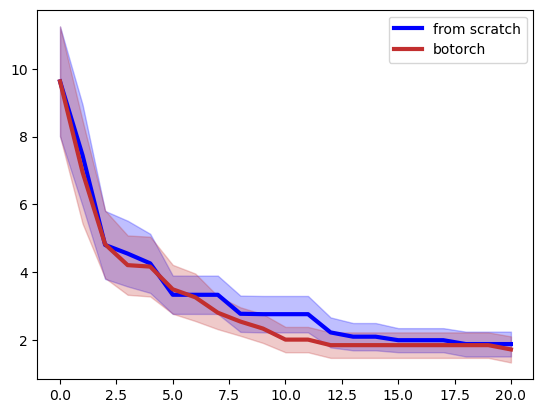

In [25]:
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Beale2D_BO_EI'), delimiter=',')


fstar = 0.
N = 20

total_record = (np.array(BO_EI)-fstar)[:N,:]
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='from scratch',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = -np.array(BO_res1)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='botorch',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

plt.legend()

# try

In [26]:
#!/usr/bin/env python3
# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

r"""
Analytic Acquisition Functions that evaluate the posterior without performing
Monte-Carlo sampling.
"""
from botorch.acquisition import AnalyticAcquisitionFunction

from __future__ import annotations

import math

from abc import ABC

from contextlib import nullcontext
from copy import deepcopy

from typing import Dict, Optional, Tuple, Union

import torch
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.acquisition.objective import PosteriorTransform
from botorch.exceptions import UnsupportedError
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.gpytorch import GPyTorchModel
from botorch.models.model import Model
from botorch.utils.constants import get_constants_like
from botorch.utils.probability import MVNXPB
from botorch.utils.probability.utils import (
    log_ndtr as log_Phi,
    log_phi,
    log_prob_normal_in,
    ndtr as Phi,
    phi,
)
from botorch.utils.safe_math import log1mexp, logmeanexp
from botorch.utils.transforms import convert_to_target_pre_hook, t_batch_mode_transform
from torch import Tensor
from torch.nn.functional import pad


In [27]:
class LogGP_EI(AnalyticAcquisitionFunction):


    def __init__(
        self,
        model: Model,
        best_f: Union[float, Tensor],
        c: Union[float, Tensor],
        f_mean: Union[float, Tensor],
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        **kwargs,
    ):
        
        super().__init__(model=model, posterior_transform=posterior_transform, **kwargs)
        self.register_buffer("best_f", torch.as_tensor(best_f))
        self.register_buffer("c", torch.as_tensor(c))
        self.register_buffer("f_mean", torch.as_tensor(f_mean))
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:

        mean, sigma = self._mean_and_sigma(X)
        mu = mean+self.f_mean
        C = self.c+self.best_f
        out = C*Phi((math.log(C)-mu)/sigma)-torch.exp(mu+sigma**2/2)*Phi((math.log(C)-mu-sigma**2)/sigma)

  
        return out

In [28]:
class LogGP_TEI(AnalyticAcquisitionFunction):


    def __init__(
        self,
        model: Model,
        best_f: Union[float, Tensor],
        c: Union[float, Tensor],
        f_mean: Union[float, Tensor],
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        **kwargs,
    ):
        
        super().__init__(model=model, posterior_transform=posterior_transform, **kwargs)
        self.register_buffer("best_f", torch.as_tensor(best_f))
        self.register_buffer("c", torch.as_tensor(c))
        self.register_buffer("f_mean", torch.as_tensor(f_mean))
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:

        mean, sigma = self._mean_and_sigma(X)
        
        mu = mean+self.f_mean
        C = self.c+self.best_f
        part1 = C*Phi((math.log(C)-mu)/sigma)-torch.exp(mu+sigma**2/2)*Phi((math.log(C)-mu-sigma**2)/sigma)
        
        C = self.c
        part2 = C*Phi((math.log(C)-mu)/sigma)-torch.exp(mu+sigma**2/2)*Phi((math.log(C)-mu-sigma**2)/sigma)
        
        out_temp = part1-part2
        
        part3 = self.best_f*Phi(  (math.log(self.c)-mu) /sigma ) 
    
        out = out_temp+part3

  
        return out

In [47]:
class ERM(AnalyticAcquisitionFunction):


    def __init__(
        self,
        model: Model,
        fstar: Union[float, Tensor],
        mean_temp: Union[float, Tensor],
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        **kwargs,
    ):
        
        super().__init__(model=model, posterior_transform=posterior_transform, **kwargs)
        self.register_buffer("fstar", torch.as_tensor(fstar))
        self.register_buffer("mean_temp", torch.as_tensor(mean_temp))
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:

        mean_g, sigma_g = self._mean_and_sigma(X)
        mean_g = mean_g + self.mean_temp

        mu_f = self.fstar + 1/2*mean_g**2
        sigma_f = mean_g**2 * sigma_g

        gamma = (mu_f - self.fstar)/sigma_f      
        out=sigma_f * phi(gamma) + (mu_f - self.fstar) * Phi(gamma)

  
        return out

In [48]:
class LCB(AnalyticAcquisitionFunction):


    def __init__(
        self,
        model: Model,
        beta: Union[float, Tensor],
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        **kwargs,
    ):
        
        super().__init__(model=model, posterior_transform=posterior_transform, **kwargs)
        self.register_buffer("beta", torch.as_tensor(beta))
        self.maximize = maximize

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:

        mean, sigma = self._mean_and_sigma(X)
        
        out= mean - beta*sigma
        return out

In [41]:
fun = Levy(dim=2,negate=False)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
 
n_init = 4*dim
iter_num = 10*dim
N = 20

fstar =  0.
fun = Trans_function(fun,fstar,min=True)

batch_size = 1
NUM_RESTARTS = 3*dim
RAW_SAMPLES = 30*dim

In [42]:
Warped_BO_EI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            #print(i)
            train_yvar = torch.tensor(10**(-5), device=device, dtype=dtype)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            covar_module = ScaleKernel(RBFKernel())
            model = FixedNoiseGP(torch.tensor(train_X), torch.tensor(warp_Y_standard),train_yvar.expand_as(torch.tensor(warp_Y_standard)), mean_module = ZeroMean(),covar_module=covar_module)
            
            model.covar_module.base_kernel.lengthscale = torch.sqrt(torch.tensor(res[0]))
            model.covar_module.outputscale = torch.sqrt(torch.tensor(res[1]))

            
            log_EI = LogGP_EI(model=model, best_f=Y_BO.min(),c=torch.tensor(c) , f_mean=torch.tensor(mean_warp_Y)) .to(device)
            standard_next_X, _ = optimize_acqf(
                acq_function=log_EI,
                bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
                q=batch_size,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
            )
        
            X_next = unnormalize(standard_next_X, bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_EI.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [43]:
Warped_BO_TEI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            #print(i)
            train_yvar = torch.tensor(10**(-5), device=device, dtype=dtype)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            covar_module = ScaleKernel(RBFKernel())
            model = FixedNoiseGP(torch.tensor(train_X), torch.tensor(warp_Y_standard),train_yvar.expand_as(torch.tensor(warp_Y_standard)), mean_module = ZeroMean(),covar_module=covar_module)
            
            model.covar_module.base_kernel.lengthscale = torch.sqrt(torch.tensor(res[0]))
            model.covar_module.outputscale = torch.sqrt(torch.tensor(res[1]))

            
            log_TEI = LogGP_TEI(model=model, best_f=Y_BO.min(),c=torch.tensor(c) , f_mean=torch.tensor(mean_warp_Y)) .to(device)
            standard_next_X, _ = optimize_acqf(
                acq_function=log_TEI,
                bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
                q=batch_size,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
            )
        
            X_next = unnormalize(standard_next_X, bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_TEI.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
BO_ERM = []
for exp in range(N):

    print(exp)  
    seed = exp
    
    fstar0 = 0.
    Trans = False

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
                [fun(x) for x in X_BO], dtype=dtype, device=device
            ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):

        #print(iter)
        train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)
        
        train_Y = train_Y.numpy()
        train_X = train_X.numpy()
        

        fstar_standard = (fstar0 - Y_BO.mean()) / Y_BO.std()
        fstar_standard = fstar_standard.item()
        
        if not Trans:
            minimal = np.min(train_X)
            res = optimise(train_X,train_Y)
                        
            covar_module = ScaleKernel(RBFKernel())
            model = FixedNoiseGP(torch.tensor(train_X), torch.tensor(train_Y),train_yvar.expand_as(torch.tensor(train_Y)), mean_module = ZeroMean(),covar_module=covar_module)
            
            model.covar_module.base_kernel.lengthscale = torch.sqrt(torch.tensor(res[0]))
            model.covar_module.outputscale = torch.sqrt(torch.tensor(res[1]))


            # Create a batch
            EI = ExpectedImprovement(model=model, best_f=train_Y.max()) .to(device)
            X_next_normalized, _ = optimize_acqf(
                acq_function=EI,
                bounds=torch.tensor([0.,1.]*dim).reshape(-1,2).T,
                q=batch_size,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                options={'maxiter':50*dim,'maxfun':50*dim,'disp': False},
            )
            
            beta = np.sqrt(np.log(train_X.shape[0]))
            _,lcb = LCB_acquisition_opt(m,standard_bounds,beta)
            if lcb < fstar_standard:
                Trans = True
        
        else:                        
            train_Y_transform = transform(y=train_Y,fstar=fstar_standard)
            mean_temp = np.mean(train_Y_transform)
            
            res = optimise(train_X,(train_Y_transform-mean_temp))
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y_transform-mean_temp,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            standard_next_X,erm_value = ERM_acquisition_opt(m,bounds=standard_bounds,fstar=fstar_standard,mean_temp=mean_temp)
        
        
        X_next = unnormalize(torch.tensor(X_next_normalized), bounds).reshape(-1,dim)     
        Y_next = fun(X_next).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)

        best_value = float(Y_BO.min())
        best_record.append(best_value)


    best_record = np.array(best_record)+fstar
    BO_ERM.append(best_record)

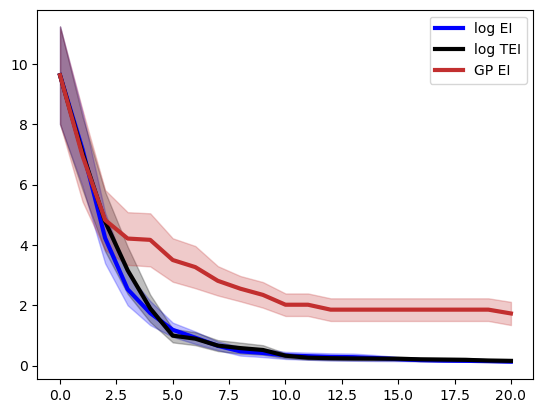

In [38]:
fstar = 0.
N = 20

total_record = (np.array(Warped_BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(Warped_BO_TEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log TEI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

total_record = -np.array(BO_res1)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

plt.legend()

In [31]:
total_record = (np.array(Warped_BO_EI))
mean = np.mean(total_record,axis=0)
mean

array([9.62640706, 7.17018366, 4.23018338, 2.5291669 , 1.74078682,
       1.18548929, 0.92370608, 0.65365309, 0.47152826, 0.41731418,
       0.33546152, 0.31041379, 0.28663348, 0.27768119, 0.24922601,
       0.21292911, 0.17901781, 0.16336354, 0.15542145, 0.14673517,
       0.12896728])

In [34]:
total_record = (np.array(Warped_BO_TEI))
mean = np.mean(total_record,axis=0)
mean

array([9.62640706, 7.0368557 , 4.77790021, 3.15894841, 1.89636167,
       0.99161704, 0.89080114, 0.661679  , 0.57850398, 0.51594669,
       0.32662712, 0.26035841, 0.24439002, 0.23574065, 0.23074649,
       0.22602432, 0.20546979, 0.19694895, 0.18872835, 0.16624918,
       0.15547986])

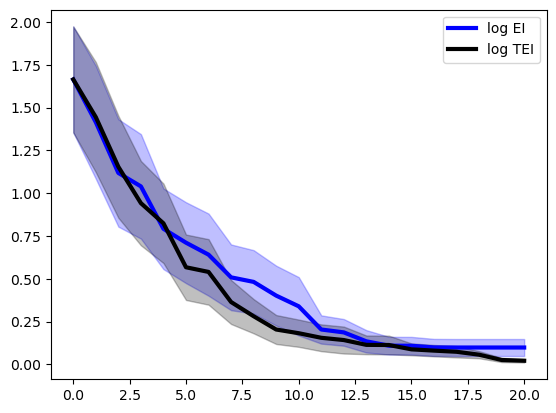

In [45]:
fstar = 0.
N = 20

total_record = (np.array(Warped_BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(Warped_BO_TEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='log TEI',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')



plt.legend()